In [33]:
## Codes adapted from: https://github.com/PotatoThanh/ADMM-NeuralNetworks/tree/master/python

import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

class ADMM_NN(object):
    def __init__(self, n_inputs, n_hiddens, n_outputs, n_batches):
        """
        Initialize variables for NN.
        Not sure how initialization affects the performance.
        The data should be in columns.
        for example, the input size of MNIST data should be (28x28, *) instead of (*, 28x28).
        Ignored bias terms.
        :param n_inputs: Number of inputs.
        :param n_hiddens: Number of hidden units.
        :param n_outputs: Number of outputs
        :param n_batches: Number of data sample that you want to train
        """
        self.a0 = np.zeros((n_inputs, n_batches))

        self.w1 = np.zeros((n_hiddens, n_inputs))
        self.w2 = np.zeros((n_hiddens, n_hiddens))
        self.w3 = np.zeros((n_outputs, n_hiddens))

        self.z1 = np.random.rand(n_hiddens, n_batches)
        self.a1 = np.random.rand(n_hiddens, n_batches)

        self.z2 = np.random.rand(n_hiddens, n_batches)
        self.a2 = np.random.rand(n_hiddens, n_batches)

        self.z3 = np.random.rand(n_outputs, n_batches)

        self.lambda_lagrange = np.ones((n_outputs, n_batches))

    def _relu(self, x):
        return tf.maximum(0.0, x)

    def _weight_update(self, layer_output, activation_input):
        """
        Consider it now the minimization of the problem with respect to W_l.
        For each layer l, the optimal solution minimizes ||z_l - W_l a_l-1||^2. This is simply
        a least square problem, and the solution is given by W_l = z_l p_l-1, where p_l-1
        represents the pseudo-inverse of the rectangular activation matrix a_l-1.
        :param layer_output: output matrix (z_l)
        :param activation_input: activation matrix l-1  (a_l-1)
        :return: weight matrix
        """
        pinv = np.linalg.pinv(activation_input)
        weight_matrix = tf.matmul(tf.cast(layer_output, tf.float32), tf.cast(pinv, tf.float32))
        return weight_matrix 

    def _activation_update(self, next_weight, next_layer_output, layer_nl_output, beta, gamma):
        """
        Minimization for a_l is a simple least squares problem similar to the weight update.
        However, in this case the matrix appears in two penalty terms in the problem, and so
        we must minimize:
            beta ||z_l+1 - W_l+1 a_l||^2 + gamma ||a_l - h(z_l)||^2
        :param next_weight:  weight matrix l+1 (w_l+1)
        :param next_layer_output: output matrix l+1 (z_l+1)
        :param layer_nl_output: activate output matrix h(z) (h(z_l))
        :param beta: value of beta
        :param gamma: value of gamma
        :return: activation matrix
        """
        layer_nl_output = self._relu(layer_nl_output)
        
        next_weight = tf.cast(next_weight, tf.float64)
        m1 = beta*tf.matmul(tf.cast(tf.matrix_transpose(next_weight), tf.float64), next_weight)
        m2 = tf.scalar_mul(gamma, tf.eye(tf.cast(m1.get_shape()[0], tf.int32)))
        av = tf.matrix_inverse(tf.cast(m1, tf.float32) + tf.cast(m2, tf.float32))

        m3 = beta*tf.matmul(tf.matrix_transpose(next_weight), tf.cast(next_layer_output, tf.float64))
        m4 = gamma*layer_nl_output 
        af = tf.cast(m3, tf.float32) + tf.cast(m4, tf.float32)

        return tf.matmul(av, af)


    def _argminz(self, a, w, a_in, z_in, beta, gamma):
        """
        This problem is non-convex and non-quadratic (because of the non-linear term h).
        Fortunately, because the non-linearity h works entry-wise on its argument, the entries
        in z_l are decoupled. This is particularly easy when h is piecewise linear, as it can
        be solved in closed form; common piecewise linear choices for h include rectified
        linear units (ReLUs), that is used here, and non-differentiable sigmoid functions.
        :param a: activation matrix (a_l)
        :param w:  weight matrix (w_l)
        :param a_in: activation matrix l-1 (a_l-1)
        :param beta: value of beta
        :param gamma: value of gamma
        :param z_in: z_l (matrix)
        :return: output matrix
        """
        m = tf.matmul(tf.cast(w, tf.float32), tf.cast(a_in, tf.float32))
        #note that z can be either postive or negative,
        #we need to compute for both possibilities and take the min
        sol1 = (gamma*a + beta*m) / (gamma + beta)  #if z>=0
        sol2 = m  #if z<0 
        
        sol1 = np.array(sol1)
        sol2 = np.array(sol2)
        z_in = np.array(z_in)
        z = np.zeros_like(z_in)
        
        z[z_in>=0.] = sol1[z_in>=0.]
        z[z_in<0.] = sol2[z_in<0.]

        return z 

    def _argminlastz(self, targets, eps, w, a_in, beta):
        """
        Minimization of the last output matrix.
        Using square error as loss term here.
        Treat lagrange as an element-wise product and find min of quadratic function.
        target(y), lambda, z_L, all same dimension
        :param targets: target matrix (equal dimensions of z) (y)
        :param eps: lagrange multiplier matrix (equal dimensions of z) (lambda)
        :param w: weight matrix (w_l)
        :param a_in: activation matrix l-1 (a_l-1)
        :param beta: value of beta
        :return: output matrix last layer
        """
        m = tf.matmul(tf.cast(w, tf.float32), tf.cast(a_in, tf.float32))
        z = (targets - eps/2 +beta*m) / (1+beta)
        return z 

    def _lambda_update(self, zl, w, a_in, beta):
        """
        Lagrange multiplier update.
        :param zl: output matrix last layer (z_L)
        :param w: weight matrix last layer (w_L)
        :param a_in: activation matrix l-1 (a_L-1)
        :param beta: value of beta
        :return: lagrange update
        """
        mpt = tf.matmul(tf.cast(w, tf.float32), tf.cast(a_in, tf.float32))
        lambda_up = beta*(zl - mpt)

        return self.lambda_lagrange + lambda_up 

    def feed_forward(self, inputs):
        """
        Calculate feed forward pass for neural network
        :param inputs: inputs features
        :return: value of prediction
        """
        outputs = self._relu(tf.matmul(self.w1, inputs))
        outputs = self._relu(tf.matmul(self.w2, outputs))
        # no activation for final layer
        outputs = tf.matmul(self.w3, outputs)
        return outputs



    def fit(self, inputs, labels, beta, gamma):
        """
        Training ADMM Neural Network by minimizing sub-problems
        :param inputs: input of training data samples
        :param outputs: label of training data samples
        :param epochs: number of epochs
        :param beta: value of beta
        :param gamma: value of gamma
        :return: loss value
        """
        self.a0 = inputs 

        # Input layer 
        self.w1 = self._weight_update(self.z1, self.a0)
        self.a1 = self._activation_update(self.w2, self.z2, self.z1, beta, gamma)
        self.z1 = self._argminz(self.a1, self.w1, self.a0, self.z1, beta, gamma) 

        # Hidden layer (use loop if many layers)
        self.w2 = self._weight_update(self.z2, self.a1)
        self.a2 = self._activation_update(self.w3, self.z3, self.z2, beta, gamma)
        self.z2 = self._argminz(self.a2, self.w2, self.a1, self.z2, beta, gamma)

        # Output layer 
        self.w3 = self._weight_update(self.z3, self.a2)
        self.z3 = self._argminlastz(labels, self.lambda_lagrange, self.w3, self.a2, beta)
        self.lambda_lagrange = self._lambda_update(self.z3, self.w3, self.a2, beta)

        loss, accuracy = self.evaluate(inputs, labels)
        return loss, accuracy 


    def evaluate(self, inputs, labels, isCategories=True):
        """
        Calculate loss and accuracy (only classification)
        :param inputs: inputs data
        :param outputs: ground truth
        :param isCategrories: classification or not
        :return: loss and accuracy (only classification)
        """
        forward = self.feed_forward(inputs)
        loss = tf.reduce_mean(tf.square(forward - labels))

        if isCategories:
            accuracy = tf.equal(tf.argmax(labels, axis=0), tf.argmax(forward, axis=0))
            accuracy = tf.reduce_sum(tf.cast(accuracy, tf.int32)) / accuracy.get_shape()[0]
        else:
            # for regression, no so-called accuracy
            accuracy = loss 

        return loss, accuracy

    def warming(self, inputs, labels, epochs, beta, gamma):
        """
        Warming ADMM Neural Network by minimizing sub-problems without update lambda for several iterations
        :param inputs: input of training data samples
        :param outputs: label of training data samples
        :param epochs: number of epochs
        :param beta: value of beta
        :param gamma: value of gamma
        :return:
        """
        self.a0 = inputs 
        for i in range(epochs):
            print("------ Warming: {:d} ------".format(i))

            #Input layer 
            self.w1 = self._weight_update(self.z1, self.a0)
            self.a1 = self._activation_update(self.w2, self.z2, self.z1, beta, gamma)
            self.z1 = self._argminz(self.a1, self.w1, self.a0, self.z1, beta, gamma) 

            #Hidden layer
            self.w2 = self._weight_update(self.z2, self.a1)
            self.a2 = self._activation_update(self.w3, self.z3, self.z2, beta, gamma)
            self.z2 = self._argminz(self.a2, self.w2, self.a1, self.z2, beta, gamma)

            # Output layer
            self.w3 = self._weight_update(self.z3, self.a2)
            self.z3 = self._argminlastz(labels, self.lambda_lagrange, self.w3, self.a2, beta)


    def drawcurve(self, train_, valid_, legend_1, legend_2):
        acc_train = np.array(train_).flatten()
        acc_test = np.array(valid_).flatten()

        plt.figure()
        plt.plot(acc_train)
        plt.plot(acc_test)

        plt.legend([legend_1, legend_2], loc="upper left")
        plt.draw()
        plt.pause(0.001) 




Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
------ Warming: 0 ------
------ Warming: 1 ------
------ Warming: 2 ------
------ Warming: 3 ------
------ Warming: 4 ------
------ Warming: 5 ------
------ Warming: 6 ------
------ Warming: 7 ------
------ Warming: 8 ------
------ Warming: 9 ------
------ Training: 0 ------
Loss train: 0.327980, accuracy train: 0.169491
Loss valid: 0.326392, accuracy valid: 0.175200


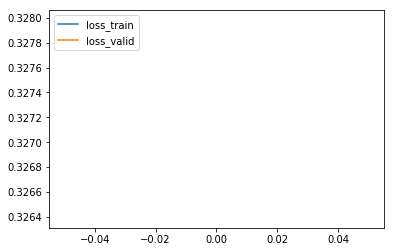

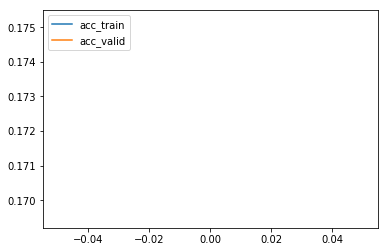

------ Training: 1 ------
Loss train: 0.327962, accuracy train: 0.203727
Loss valid: 0.326361, accuracy valid: 0.205600


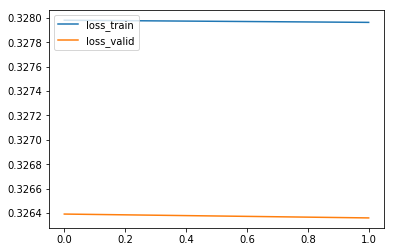

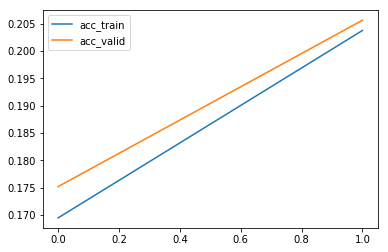

------ Training: 2 ------
Loss train: 0.327584, accuracy train: 0.235727
Loss valid: 0.325979, accuracy valid: 0.236400


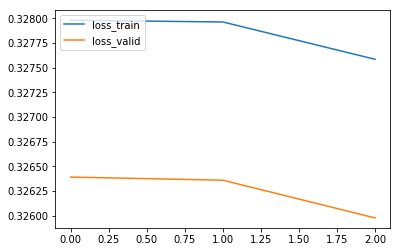

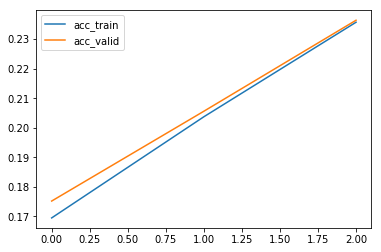

------ Training: 3 ------
Loss train: 0.327010, accuracy train: 0.270582
Loss valid: 0.325409, accuracy valid: 0.275400


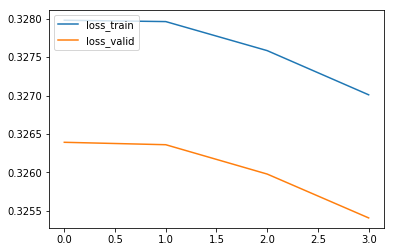

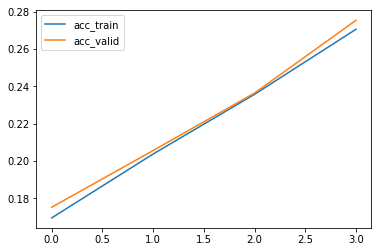

------ Training: 4 ------
Loss train: 0.326275, accuracy train: 0.311182
Loss valid: 0.324684, accuracy valid: 0.317600


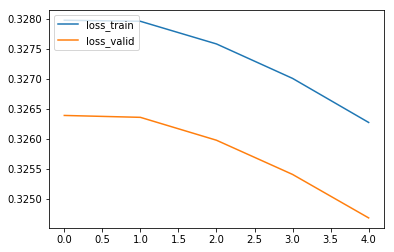

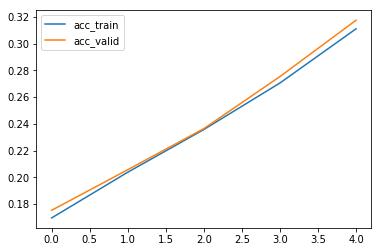

------ Training: 5 ------
Loss train: 0.325391, accuracy train: 0.354327
Loss valid: 0.323812, accuracy valid: 0.361000


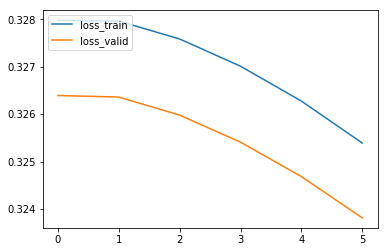

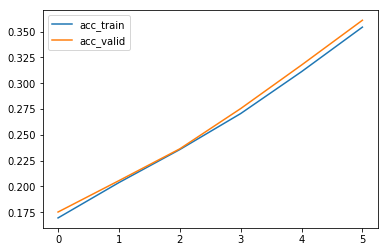

------ Training: 6 ------
Loss train: 0.324370, accuracy train: 0.398582
Loss valid: 0.322805, accuracy valid: 0.408600


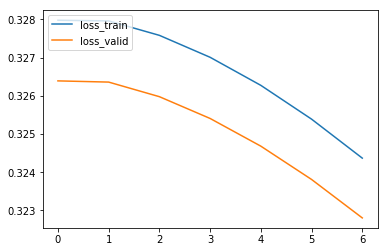

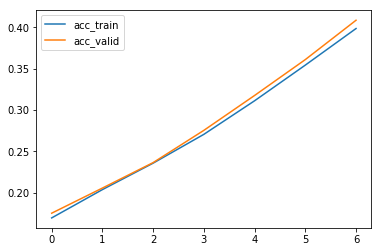

------ Training: 7 ------
Loss train: 0.323232, accuracy train: 0.443164
Loss valid: 0.321683, accuracy valid: 0.448800


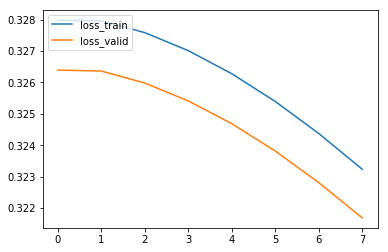

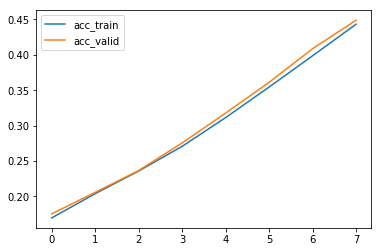

------ Training: 8 ------
Loss train: 0.322004, accuracy train: 0.483964
Loss valid: 0.320471, accuracy valid: 0.489400


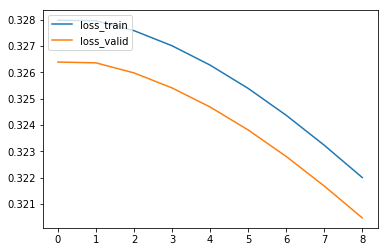

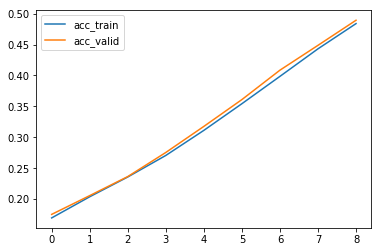

------ Training: 9 ------
Loss train: 0.320722, accuracy train: 0.520855
Loss valid: 0.319201, accuracy valid: 0.527200


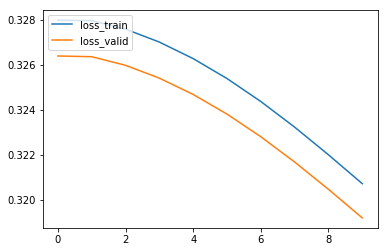

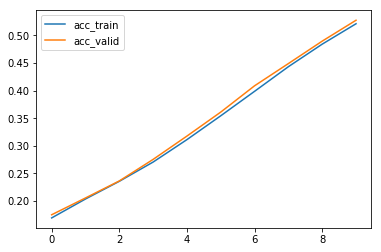

------ Training: 10 ------
Loss train: 0.319425, accuracy train: 0.554036
Loss valid: 0.317918, accuracy valid: 0.560200


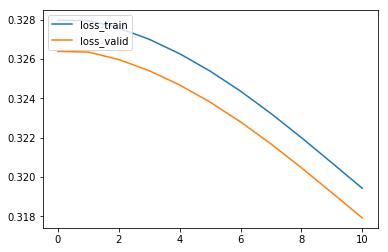

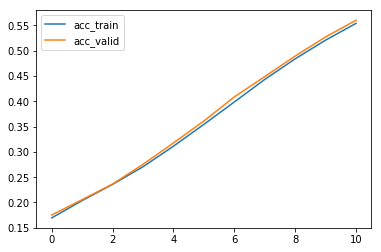

------ Training: 11 ------
Loss train: 0.318146, accuracy train: 0.582509
Loss valid: 0.316655, accuracy valid: 0.590200


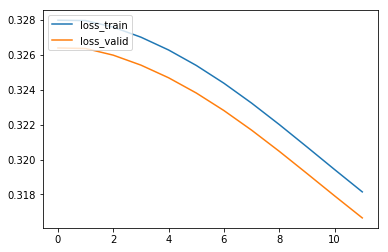

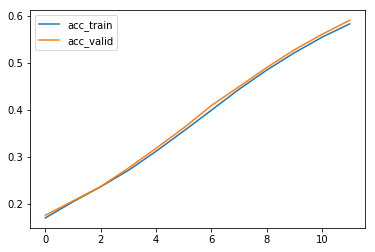

------ Training: 12 ------
Loss train: 0.316921, accuracy train: 0.606836
Loss valid: 0.315445, accuracy valid: 0.616600


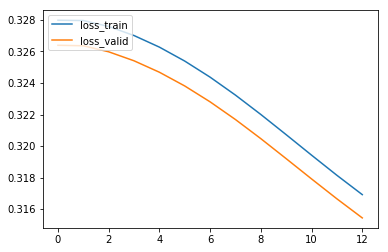

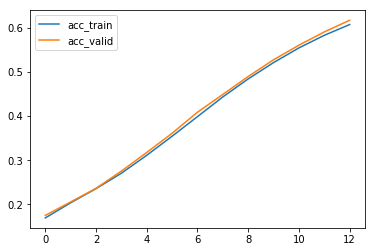

------ Training: 13 ------
Loss train: 0.315773, accuracy train: 0.628436
Loss valid: 0.314311, accuracy valid: 0.637200


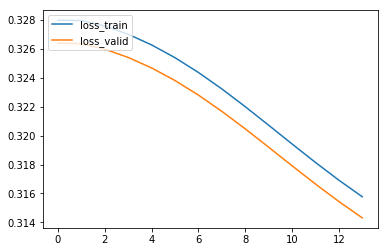

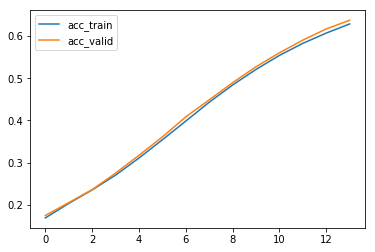

------ Training: 14 ------
Loss train: 0.314718, accuracy train: 0.646055
Loss valid: 0.313267, accuracy valid: 0.656800


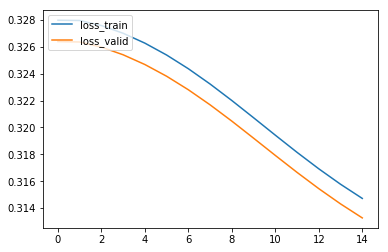

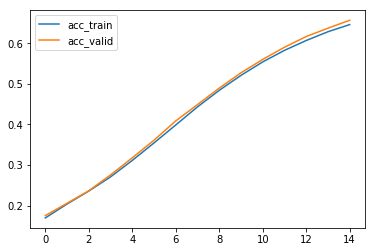

------ Training: 15 ------
Loss train: 0.313763, accuracy train: 0.661818
Loss valid: 0.312320, accuracy valid: 0.674600


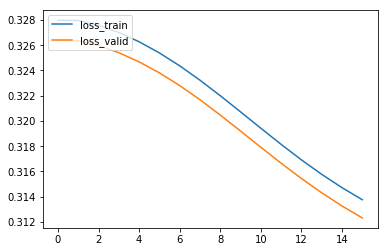

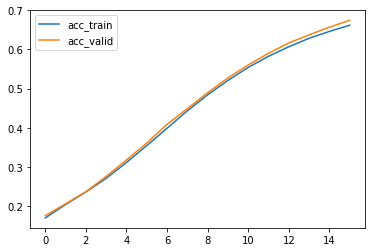

------ Training: 16 ------
Loss train: 0.312907, accuracy train: 0.674600
Loss valid: 0.311471, accuracy valid: 0.687800


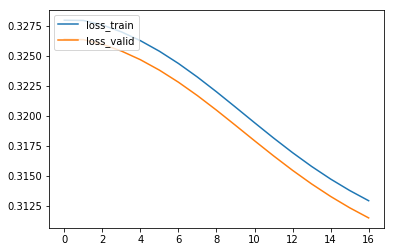

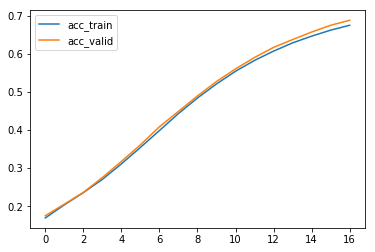

------ Training: 17 ------
Loss train: 0.312149, accuracy train: 0.685982
Loss valid: 0.310717, accuracy valid: 0.698400


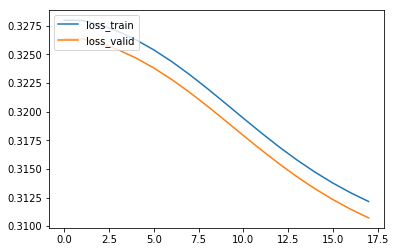

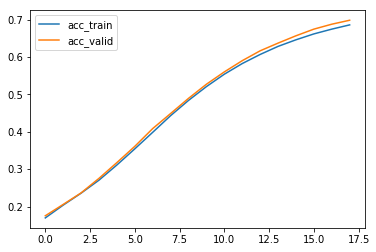

------ Training: 18 ------
Loss train: 0.311479, accuracy train: 0.695145
Loss valid: 0.310050, accuracy valid: 0.708800


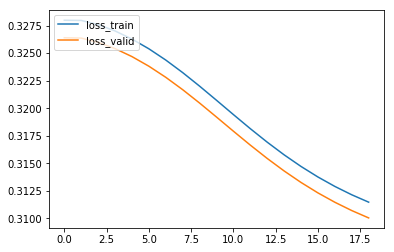

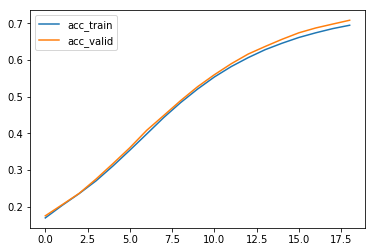

------ Training: 19 ------
Loss train: 0.310894, accuracy train: 0.703418
Loss valid: 0.309465, accuracy valid: 0.717200


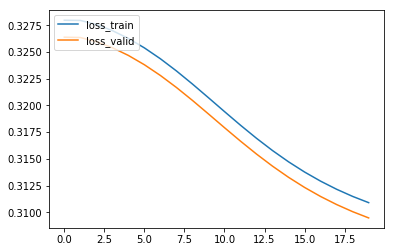

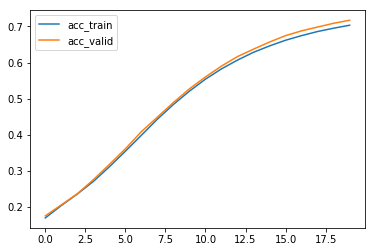

------ Training: 20 ------
Loss train: 0.310381, accuracy train: 0.710564
Loss valid: 0.308952, accuracy valid: 0.723000


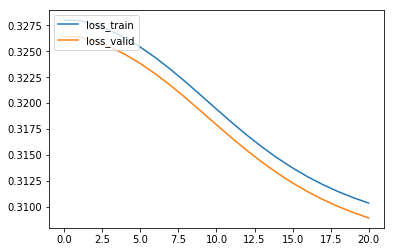

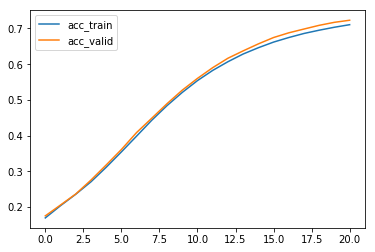

------ Training: 21 ------
Loss train: 0.309932, accuracy train: 0.717236
Loss valid: 0.308505, accuracy valid: 0.729000


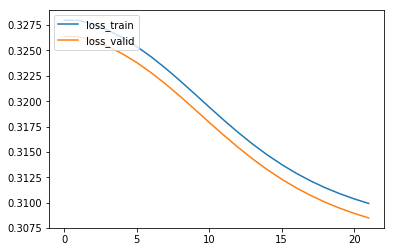

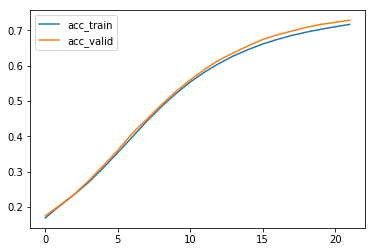

------ Training: 22 ------
Loss train: 0.309540, accuracy train: 0.722564
Loss valid: 0.308115, accuracy valid: 0.733800


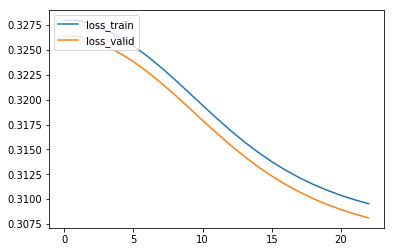

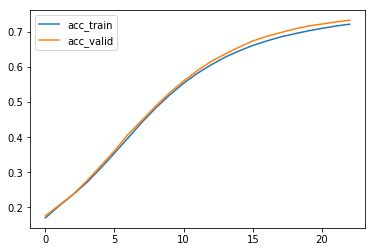

------ Training: 23 ------
Loss train: 0.309198, accuracy train: 0.726673
Loss valid: 0.307773, accuracy valid: 0.738800


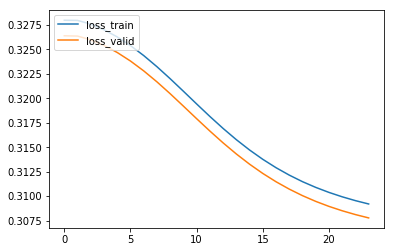

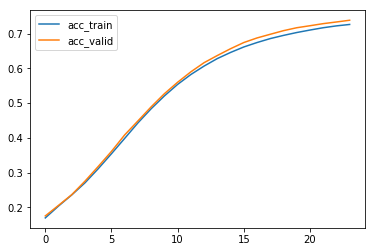

------ Training: 24 ------
Loss train: 0.308897, accuracy train: 0.731164
Loss valid: 0.307475, accuracy valid: 0.742400


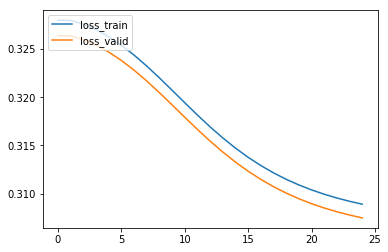

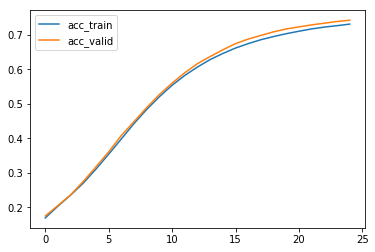

Loss valid: 0.315679, accuracy valid: 0.734500


In [36]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.contrib.eager as tfe
#from ADMM import ADMM_NN
from tensorflow.examples.tutorials.mnist import input_data

#tfe.enable_eager_execution()

mnist = input_data.read_data_sets("./data/", one_hot=True)

trainX = np.transpose(mnist.train.images).astype(np.float32)
trainY = np.transpose(mnist.train.labels).astype(np.float32)

validX = np.transpose(mnist.validation.images).astype(np.float32)
validY = np.transpose(mnist.validation.labels).astype(np.float32)

testX = np.transpose(mnist.test.images).astype(np.float32)
testY = np.transpose(mnist.test.labels).astype(np.float32)

# parameters 
n_inputs = 28*28
n_outputs = 10
n_hiddens = 256 
n_batches = np.shape(trainX)[1]
train_epochs = 25 
warm_epochs = 10 

# these parameters are used in the paper 
# theoretically can converge with any hyperparameters
# can tune these to check the effect
beta = 1.0
gamma = 10.0

model = ADMM_NN(n_inputs, n_hiddens, n_outputs, n_batches)

model.warming(trainX, trainY, warm_epochs, beta, gamma)

list_loss_train = []
list_loss_valid = []
list_accuracy_train = []
list_accuracy_valid = []

for i in range(train_epochs):
    print("------ Training: {:d} ------".format(i))
    loss_train, accuracy_train = model.fit(trainX, trainY, beta, gamma)
    loss_valid, accuracy_valid = model.evaluate(validX, validY)

    print("Loss train: %3f, accuracy train: %3f" % (np.array(loss_train), np.array(accuracy_train)))
    print("Loss valid: %3f, accuracy valid: %3f" % (np.array(loss_valid), np.array(accuracy_valid)))

    list_loss_train.append(np.array(loss_train))
    list_loss_valid.append(np.array(loss_valid))
    list_accuracy_train.append(np.array(accuracy_train))
    list_accuracy_valid.append(np.array(accuracy_valid))

    # Drawing loss, accuracy of train and valid
    model.drawcurve(list_loss_train, list_loss_valid, 'loss_train', 'loss_valid')
    model.drawcurve(list_accuracy_train, list_accuracy_valid, 'acc_train', 'acc_valid')


# Evaluate model on test set
loss, accuracy = model.evaluate(testX, testY)
print("Loss valid: %3f, accuracy valid: %3f" % (loss, accuracy))

